### Train the transformer model

+ Since our previous attempts to use neural networks (LSTM + linear layer / Seq2Seq LSTM) were not very successful, especially on imperfect time series (where the data distribution changes from train to test), it was decided to try a different approach: using a transformer model.

+ We already saw that Seq2Seq performs better than the LSTM + linear layer. Hence, it makes sense to try a more advanced neural network architecture to see if it will be able to capture the complex temporal dependencies in the data. However, since the dataset is not very big, it is expected that the transformer model will be overfitting, and the results will be worse than the already obtained ones. Nevertheless, it is worth trying to see if the transformer model can be used to improve the forecasting performance.

+ We will not write a PyTorch pipeline for training the transformer. Instead, we will use the pytorch_forecasting and lightning.pytorch libraries that will allow us to build the end-to-end pipeline.

We will use the following reference: https://pytorch-forecasting.readthedocs.io/en/stable/tutorials/stallion.html

In [1]:
import pandas as pd
import torch
pd.set_option('display.float_format', '{:.6f}'.format)

In [2]:
from split_data import split_dataframe
from normalisation import standardize_data
df_h1 = pd.read_csv('ETT-small/ETTh1.csv')
df_h1['date'] = pd.to_datetime(df_h1['date'])
df_h2 = pd.read_csv('ETT-small/ETTh2.csv')
df_h2['date'] = pd.to_datetime(df_h2['date'])
df_m1 = pd.read_csv('ETT-small/ETTm1.csv')
df_m1['date'] = pd.to_datetime(df_m1['date'])
df_m2 = pd.read_csv('ETT-small/ETTm2.csv')
df_m2['date'] = pd.to_datetime(df_m2['date'])
train_h1, val_h1, test_h1 = split_dataframe(df_h1)
train_h1, val_h1, test_h1 = standardize_data(train_h1, val_h1, test_h1)
train_h2, val_h2, test_h2 = split_dataframe(df_h2)
train_h2, val_h2, test_h2 = standardize_data(train_h2, val_h2, test_h2)
train_m1, val_m1, test_m1 = split_dataframe(df_m1)
train_m1, val_m1, test_m1 = standardize_data(train_m1, val_m1, test_m1)
train_m2, val_m2, test_m2 = split_dataframe(df_m2)
train_m2, val_m2, test_m2 = standardize_data(train_m2, val_m2, test_m2)

In [3]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:1


In [4]:
metrics = pd.DataFrame(columns=['model', 'prediction_length', 'dataset', 'mse', 'mae'])
metrics

,model,prediction_length,dataset,mse,mae


### Train transformer

I tried hyperparameters tuning on h1, but it did not improve the results much. Hence, I will train the model for each setup and dataset only one time: using the default hyperparameters, and using the hyperparameters suggested in the reference article

##### h1, prediction length = 96

In [5]:
from transformer_model import prepare_data, train_transformer, evaluate_transformer_model

In [6]:
training_h1, validation_h1, test_set_h1, train_dataloader_h1, val_dataloader_h1, test_dataloader_h1 = prepare_data(train_h1, val_h1, test_h1, max_encoder_length=96, max_prediction_length=96, batch_size=256)

In [ ]:
transformer_model_v1_h1_96 = train_transformer(training_h1, train_dataloader_h1, val_dataloader_h1, save_file_name='transformer_v1_h1_96')

In [ ]:
predictions = transformer_model_v1_h1_96.predict(test_dataloader_h1)
predictions = predictions.cpu().numpy() if isinstance(predictions, torch.Tensor) else predictions
predictions = predictions[0]

Mean Squared Error (MSE): 0.4290
Mean Absolute Error (MAE): 0.6186
Plot saved as results_images/transformer_h1_96.png


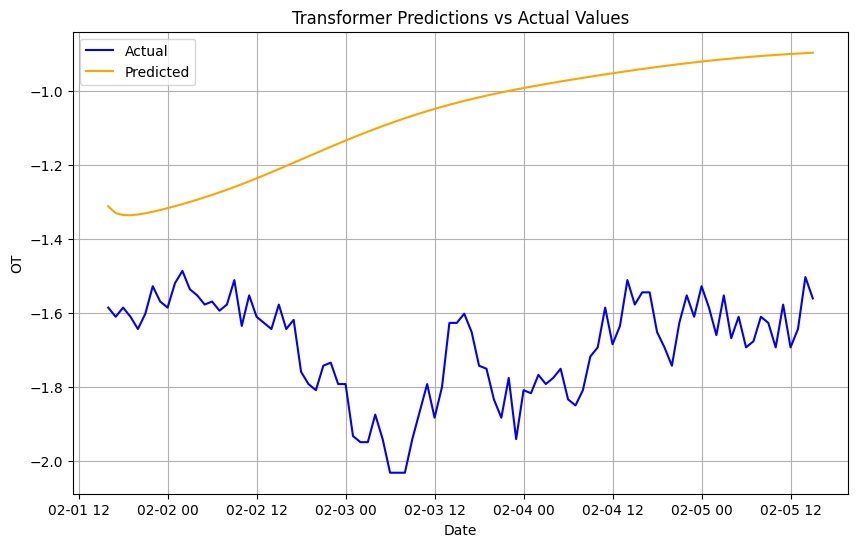

In [9]:
mse_transformer_v1_h1_96, mae_transformer_v1_h1_96 = evaluate_transformer_model(predictions, test_h1, save_plot=True, plot_filename="results_images/transformer_h1_96.png")

In [10]:
metrics

,model,prediction_length,dataset,mse,mae


In [ ]:
new_row = pd.DataFrame([['transformer', 96, 'h1', mse_transformer_v1_h1_96, mae_transformer_v1_h1_96]],
                       columns=metrics.columns)
metrics = pd.concat([metrics, new_row], ignore_index=True)
# save metrics dataframe every time we append it so that the results are not lost
metrics.to_csv('metrics.csv', index=False)
metrics

##### h1, prediction length = 192

In [ ]:
training_h1, validation_h1, test_set_h1, train_dataloader_h1, val_dataloader_h1, test_dataloader_h1 = prepare_data(train_h1, val_h1, test_h1, max_encoder_length=96, max_prediction_length=192, batch_size=256)
transformer_model_h1_192 = train_transformer(training_h1, train_dataloader_h1, val_dataloader_h1, save_file_name='transformer_h1_192', max_prediction_length=192, hidden_size=64, hidden_continuous_size=32, attention_head_size=2, dropout=0.3)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/home/alex/anaconda3/envs/test/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Mean Squared Error (MSE): 0.5260
Mean Absolute Error (MAE): 0.7120
Plot saved as results_images/transformer_h1_192.png


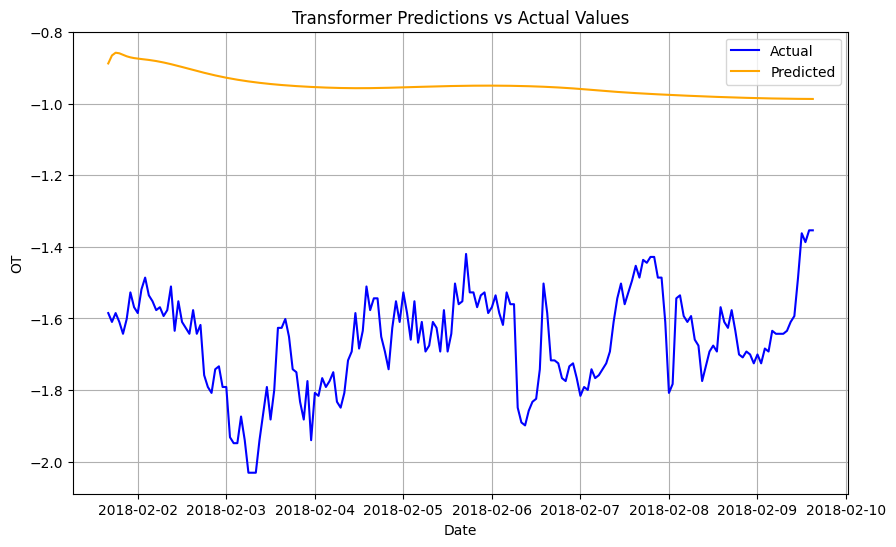

,model,prediction_length,dataset,mse,mae
0,transformer,96,h1,0.428979,0.618615
1,transformer,192,h1,0.525991,0.712006


In [13]:
predictions = transformer_model_h1_192.predict(test_dataloader_h1)
predictions = predictions.cpu().numpy() if isinstance(predictions, torch.Tensor) else predictions
predictions = predictions[0]

mse_transformer_h1_192, mae_transformer_h1_192 = evaluate_transformer_model(predictions, test_h1, n_steps=192, save_plot=True, plot_filename="results_images/transformer_h1_192.png")

new_row = pd.DataFrame([['transformer', 192, 'h1', mse_transformer_h1_192, mae_transformer_h1_192]],
                       columns=metrics.columns)
metrics = pd.concat([metrics, new_row], ignore_index=True)
metrics.to_csv('metrics.csv', index=False)
metrics

##### h2, prediction length = 96

In [14]:
from transformer_model import forecast_and_save_results

Seed set to 42
Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/alex/anaconda3/envs/test/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/alex/anaconda3/envs/test/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
/home/ale

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/alex/anaconda3/envs/test/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.
/home/alex/anaconda3/envs/test/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.
/home/alex/anaconda3/envs/test/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (40) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.216


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.216. Signaling Trainer to stop.
Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/home/alex/anaconda3/envs/test/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve

Mean Squared Error (MSE): 4.8906
Mean Absolute Error (MAE): 2.1723
Plot saved as results_images/transformer_h2_96.png


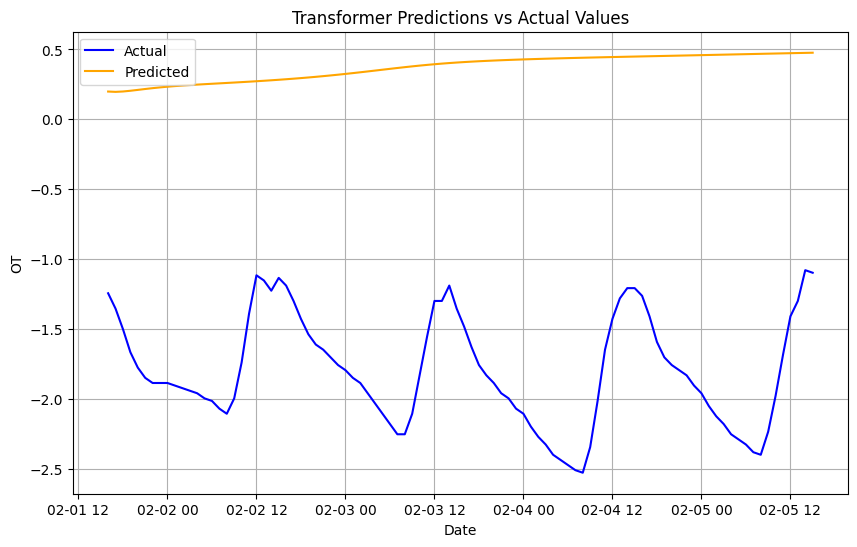

,model,prediction_length,dataset,mse,mae
0,transformer,96,h1,0.428979,0.618615
1,transformer,192,h1,0.525991,0.712006
2,transformer,96,h2,4.890585,2.172268


In [16]:
metrics = forecast_and_save_results(train_h2, val_h2, test_h2, 'h2', max_encoder_length=96, max_prediction_length=96, save_file_name='transformer_h2_96', plot_filename="results_images/transformer_h2_96.png", metrics=metrics)
metrics.to_csv('metrics.csv', index=False)
metrics

### Bad performance

As we see, the transformer model could not forecast the simplest data with good distribution well. Hence, there is no point in doing experiments with the transformer model further

In [21]:
metrics.to_csv('transformer_metrics.csv', index=False)

### References

https://pytorch-forecasting.readthedocs.io/en/stable/tutorials/stallion.html